# Article Length Bias Analysis

Analyze whether the model's predictions are biased by article length, or if it truly learns semantic content.

**Key tests:**
1. Length distribution by class
2. Prediction vs length correlation
3. Length-controlled accuracy
4. **Truncation test** - Do predictions change when we fix length?
5. **Word shuffle test** - Do predictions change when content is destroyed?
6. **Length-matched comparison** - Accuracy within length-controlled subsets

In [3]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from transformers import DistilBertModel, DistilBertTokenizerFast
from tqdm import tqdm
import random

import transformer.config as config
from transformer.model import TransformerClassifier, DebiasedTransformerClassifier
from preprocess import load_cached_data

plt.style.use('seaborn-v0_8-whitegrid')
random.seed(42)

In [4]:
# Load model
ensemble_info = torch.load(config.CACHE_DIR / 'transformer_ensemble_info.pt', weights_only=True)
best_fold = ensemble_info['top_indices'][-1]
checkpoint = torch.load(config.CACHE_DIR / f'transformer_model_fold_{best_fold}.pt', weights_only=True)

bert = DistilBertModel.from_pretrained(config.TRANSFORMER_MODEL)
tokenizer = DistilBertTokenizerFast.from_pretrained(config.TRANSFORMER_MODEL)

# Load correct model type based on checkpoint
is_debiased = checkpoint.get('debiased', False)
print(f'Model type: {"Debiased" if is_debiased else "Standard"}')

if is_debiased:
    model = DebiasedTransformerClassifier(
        input_dim=768, hidden_dim=256, dropout=0.5,
        num_extra_features=checkpoint.get('num_extra_features', 0),
        gradient_reversal_lambda=config.GRADIENT_REVERSAL_LAMBDA
    )
else:
    model = TransformerClassifier(
        input_dim=768, hidden_dim=256, dropout=0.5,
        num_extra_features=checkpoint.get('num_extra_features', 0)
    )
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
bert.eval()

def predict(text):
    encoding = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding=True)
    with torch.no_grad():
        outputs = bert(**encoding)
        cls_embedding = outputs.last_hidden_state[:, 0]
        return model(cls_embedding).item()

print(f'Loaded fold {best_fold} (F1={ensemble_info["fold_scores"][best_fold]:.4f})')

Model type: Debiased
Loaded fold 8 (F1=0.8696)


In [5]:
# Load and process test data
test_data = load_cached_data('test_byarticle')
print(f'Test articles: {len(test_data)}')

results = []
for article in tqdm(test_data, desc='Predicting'):
    text = article['text']
    label = article['label']
    prob = predict(text)
    
    results.append({
        'id': article['id'],
        'text': text,
        'label': label,
        'prob': prob,
        'pred': 1 if prob > 0.5 else 0,
        'correct': int((prob > 0.5) == label),
        'word_len': len(text.split()),
        'token_len': len(tokenizer.encode(text, truncation=True, max_length=512)),
    })

df = pd.DataFrame(results)
df['label_name'] = df['label'].map({0: 'Mainstream', 1: 'Hyperpartisan'})
print(f'Overall accuracy: {df["correct"].mean():.3f}')

Test articles: 628


Predicting: 100%|██████████| 628/628 [00:37<00:00, 16.79it/s]


Overall accuracy: 0.820


## 1. Length Distribution by Class

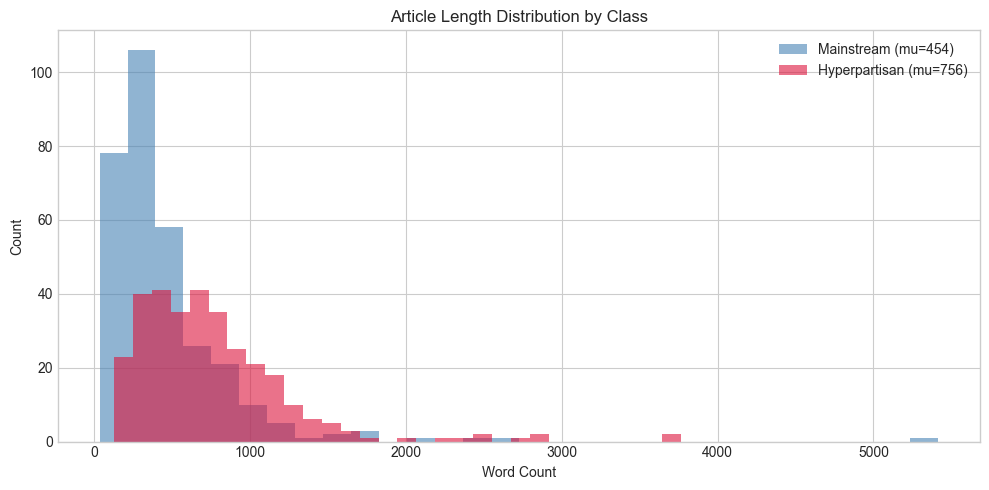

T-test (H vs M length): t=7.83, p=0.0000
Mean length: Hyperpartisan=756, Mainstream=454


In [6]:
fig, ax = plt.subplots(figsize=(10, 5))

for label, color in [(0, 'steelblue'), (1, 'crimson')]:
    subset = df[df['label'] == label]['word_len']
    ax.hist(subset, bins=30, alpha=0.6, color=color,
            label=f"{'Mainstream' if label == 0 else 'Hyperpartisan'} (mu={subset.mean():.0f})")

ax.set_xlabel('Word Count')
ax.set_ylabel('Count')
ax.set_title('Article Length Distribution by Class')
ax.legend()
plt.tight_layout()
plt.show()

# T-test for length difference
hyper_len = df[df['label'] == 1]['word_len']
main_len = df[df['label'] == 0]['word_len']
t_stat, p_val = stats.ttest_ind(hyper_len, main_len)
print(f'T-test (H vs M length): t={t_stat:.2f}, p={p_val:.4f}')
print(f'Mean length: Hyperpartisan={hyper_len.mean():.0f}, Mainstream={main_len.mean():.0f}')

## 2. Prediction vs Length Correlation

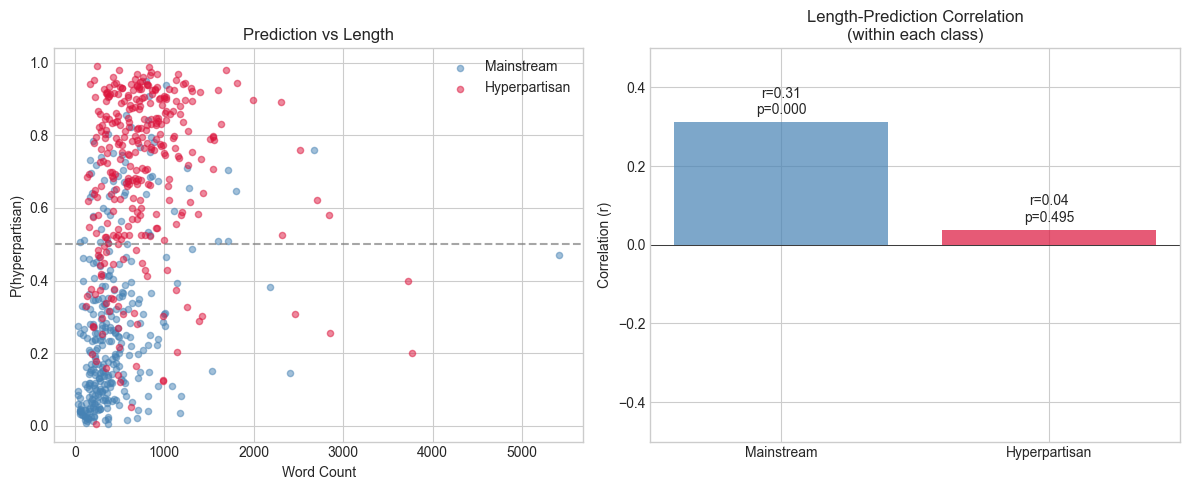


Interpretation:
If r~0 within each class, the model is NOT using length as a shortcut.
If r is high within a class, predictions correlate with length independent of content.


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot
ax = axes[0]
for label, color in [(0, 'steelblue'), (1, 'crimson')]:
    subset = df[df['label'] == label]
    ax.scatter(subset['word_len'], subset['prob'], alpha=0.5, c=color, s=20,
               label='Mainstream' if label == 0 else 'Hyperpartisan')
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.7)
ax.set_xlabel('Word Count')
ax.set_ylabel('P(hyperpartisan)')
ax.legend()
ax.set_title('Prediction vs Length')

# Correlation within each class
ax = axes[1]
for label, color, name in [(0, 'steelblue', 'Mainstream'), (1, 'crimson', 'Hyperpartisan')]:
    subset = df[df['label'] == label]
    r, p = stats.pearsonr(subset['word_len'], subset['prob'])
    ax.bar(name, r, color=color, alpha=0.7)
    ax.text(name, r + 0.02 * np.sign(r), f'r={r:.2f}\np={p:.3f}', ha='center', fontsize=10)

ax.axhline(0, color='black', linewidth=0.5)
ax.set_ylabel('Correlation (r)')
ax.set_title('Length-Prediction Correlation\n(within each class)')
ax.set_ylim(-0.5, 0.5)

plt.tight_layout()
plt.show()

print('\nInterpretation:')
print('If r~0 within each class, the model is NOT using length as a shortcut.')
print('If r is high within a class, predictions correlate with length independent of content.')

## 3. Truncation Test (Critical!)

**Test:** Truncate ALL articles to the same length (e.g., 100 words). If the model learned content, accuracy should remain reasonable. If it learned length, accuracy will drop to random.

In [8]:
def truncate_words(text, max_words):
    words = text.split()
    return ' '.join(words[:max_words])

truncation_results = []

for max_words in [50, 100, 150, 200, 300, 512]:
    correct = 0
    total = 0
    for _, row in df.iterrows():
        truncated = truncate_words(row['text'], max_words)
        prob = predict(truncated)
        pred = 1 if prob > 0.5 else 0
        correct += int(pred == row['label'])
        total += 1
    
    acc = correct / total
    truncation_results.append({'max_words': max_words, 'accuracy': acc})
    print(f'Truncated to {max_words} words: Accuracy = {acc:.3f}')

trunc_df = pd.DataFrame(truncation_results)

Truncated to 50 words: Accuracy = 0.705
Truncated to 100 words: Accuracy = 0.732
Truncated to 150 words: Accuracy = 0.763
Truncated to 200 words: Accuracy = 0.791
Truncated to 300 words: Accuracy = 0.793
Truncated to 512 words: Accuracy = 0.820


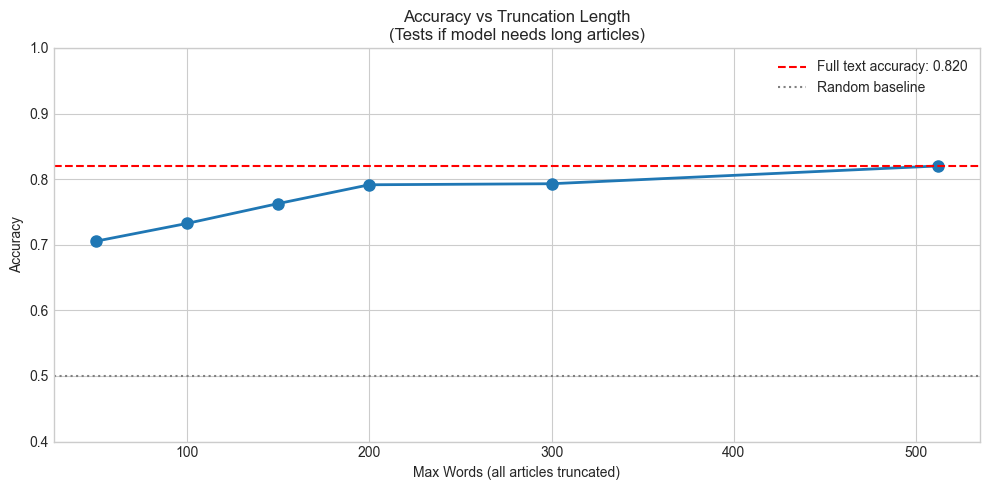


Interpretation:
If accuracy stays high even at 100 words -> Model learned CONTENT
If accuracy drops significantly -> Model may rely on length cues


In [9]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(trunc_df['max_words'], trunc_df['accuracy'], 'o-', linewidth=2, markersize=8)
ax.axhline(df['correct'].mean(), color='red', linestyle='--', label=f'Full text accuracy: {df["correct"].mean():.3f}')
ax.axhline(0.5, color='gray', linestyle=':', label='Random baseline')

ax.set_xlabel('Max Words (all articles truncated)')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs Truncation Length\n(Tests if model needs long articles)')
ax.legend()
ax.set_ylim(0.4, 1.0)

plt.tight_layout()
plt.show()

print('\nInterpretation:')
print('If accuracy stays high even at 100 words -> Model learned CONTENT')
print('If accuracy drops significantly -> Model may rely on length cues')

## 4. Word Shuffle Test (Critical!)

**Test:** Shuffle words in each article. If the model learned semantic meaning, accuracy should drop significantly. If it learned shallow features (length, word frequencies), accuracy may stay similar.

In [10]:
def shuffle_words(text):
    words = text.split()
    random.shuffle(words)
    return ' '.join(words)

shuffle_results = []

for _, row in tqdm(df.iterrows(), total=len(df), desc='Shuffling'):
    shuffled = shuffle_words(row['text'])
    prob_shuffled = predict(shuffled)
    
    shuffle_results.append({
        'id': row['id'],
        'label': row['label'],
        'prob_original': row['prob'],
        'prob_shuffled': prob_shuffled,
        'pred_original': row['pred'],
        'pred_shuffled': 1 if prob_shuffled > 0.5 else 0,
    })

shuffle_df = pd.DataFrame(shuffle_results)
shuffle_df['correct_original'] = (shuffle_df['pred_original'] == shuffle_df['label']).astype(int)
shuffle_df['correct_shuffled'] = (shuffle_df['pred_shuffled'] == shuffle_df['label']).astype(int)

Shuffling: 100%|██████████| 628/628 [00:36<00:00, 17.44it/s]


Accuracy (original): 0.820
Accuracy (shuffled): 0.699
Delta Accuracy: 0.121


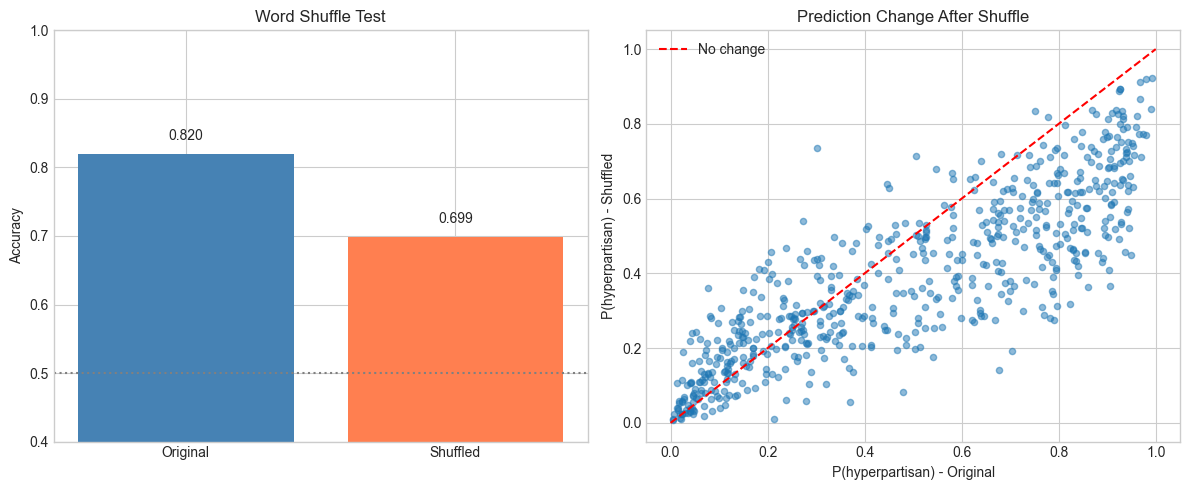


Correlation (original vs shuffled): r=0.851, p=0.0000

Interpretation:
If accuracy drops significantly -> Model learned SEMANTIC CONTENT
If accuracy stays similar -> Model learned SHALLOW FEATURES (bag-of-words, length)


In [11]:
acc_original = shuffle_df['correct_original'].mean()
acc_shuffled = shuffle_df['correct_shuffled'].mean()

print(f'Accuracy (original): {acc_original:.3f}')
print(f'Accuracy (shuffled): {acc_shuffled:.3f}')
print(f'Delta Accuracy: {acc_original - acc_shuffled:.3f}')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
ax = axes[0]
bars = ax.bar(['Original', 'Shuffled'], [acc_original, acc_shuffled], color=['steelblue', 'coral'])
ax.axhline(0.5, color='gray', linestyle=':', label='Random')
ax.set_ylabel('Accuracy')
ax.set_title('Word Shuffle Test')
ax.set_ylim(0.4, 1.0)
for bar, val in zip(bars, [acc_original, acc_shuffled]):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', ha='center')

# Scatter: original vs shuffled predictions
ax = axes[1]
ax.scatter(shuffle_df['prob_original'], shuffle_df['prob_shuffled'], alpha=0.5, s=20)
ax.plot([0, 1], [0, 1], 'r--', label='No change')
ax.set_xlabel('P(hyperpartisan) - Original')
ax.set_ylabel('P(hyperpartisan) - Shuffled')
ax.set_title('Prediction Change After Shuffle')
ax.legend()

plt.tight_layout()
plt.show()

r, p = stats.pearsonr(shuffle_df['prob_original'], shuffle_df['prob_shuffled'])
print(f'\nCorrelation (original vs shuffled): r={r:.3f}, p={p:.4f}')
print('\nInterpretation:')
print('If accuracy drops significantly -> Model learned SEMANTIC CONTENT')
print('If accuracy stays similar -> Model learned SHALLOW FEATURES (bag-of-words, length)')

## 5. Length-Matched Comparison

In [12]:
# Find overlapping length range
hyper_lens = df[df['label'] == 1]['word_len']
main_lens = df[df['label'] == 0]['word_len']

overlap_min = max(hyper_lens.min(), main_lens.min())
overlap_max = min(hyper_lens.max(), main_lens.max())

print(f'Overlapping length range: {overlap_min:.0f} - {overlap_max:.0f} words')

df_overlap = df[(df['word_len'] >= overlap_min) & (df['word_len'] <= overlap_max)]
print(f'Articles in overlapping range: {len(df_overlap)} / {len(df)}')

acc_overlap = df_overlap['correct'].mean()
print(f'\nAccuracy (length-controlled): {acc_overlap:.3f}')
print(f'Accuracy (full dataset): {df["correct"].mean():.3f}')

Overlapping length range: 126 - 3764 words
Articles in overlapping range: 595 / 628

Accuracy (length-controlled): 0.813
Accuracy (full dataset): 0.820


In [13]:
print('Accuracy by class (length-controlled subset):')
for label, name in [(0, 'Mainstream'), (1, 'Hyperpartisan')]:
    subset = df_overlap[df_overlap['label'] == label]
    acc = subset['correct'].mean()
    print(f'  {name}: {acc:.3f} (n={len(subset)})')

Accuracy by class (length-controlled subset):
  Mainstream: 0.804 (n=281)
  Hyperpartisan: 0.822 (n=314)


## 6. Final Summary

In [14]:
print('=' * 60)
print('LENGTH BIAS ANALYSIS - FINAL SUMMARY')
print('=' * 60)

# 1. Length correlation
r_all, _ = stats.pearsonr(df['word_len'], df['prob'])
print(f'\n1. Length-Prediction Correlation: r={r_all:.3f}')
if abs(r_all) > 0.3:
    print('   Warning: Strong correlation - investigate further')
else:
    print('   OK: Weak/no correlation')

# 2. Within-class correlation
r_hyper, _ = stats.pearsonr(df[df['label']==1]['word_len'], df[df['label']==1]['prob'])
r_main, _ = stats.pearsonr(df[df['label']==0]['word_len'], df[df['label']==0]['prob'])
print(f'\n2. Within-Class Correlation:')
print(f'   Hyperpartisan: r={r_hyper:.3f}')
print(f'   Mainstream: r={r_main:.3f}')
if max(abs(r_hyper), abs(r_main)) < 0.2:
    print('   OK: Length not driving predictions within classes')
else:
    print('   Warning: Length affects predictions even within same class')

# 3. Truncation stability
acc_100 = trunc_df[trunc_df['max_words'] == 100]['accuracy'].values[0]
acc_full = df['correct'].mean()
print(f'\n3. Truncation Test (100 words):')
print(f'   Accuracy at 100 words: {acc_100:.3f}')
print(f'   Accuracy full text: {acc_full:.3f}')
if acc_100 > 0.65:
    print('   OK: Model works well even on short truncated text')
else:
    print('   Warning: Performance degrades significantly with truncation')

# 4. Shuffle test
shuffle_drop = acc_original - acc_shuffled
print(f'\n4. Word Shuffle Test:')
print(f'   Accuracy drop after shuffle: {shuffle_drop:.3f}')
if shuffle_drop > 0.1:
    print('   OK: Model relies on word ORDER/CONTEXT (semantic understanding)')
else:
    print('   Warning: Model may rely on bag-of-words features')

# Overall verdict
print('\n' + '=' * 60)
issues = 0
if abs(r_all) > 0.3: issues += 1
if max(abs(r_hyper), abs(r_main)) > 0.2: issues += 1
if acc_100 < 0.65: issues += 1
if shuffle_drop < 0.1: issues += 1

if issues == 0:
    print('VERDICT: NO SIGNIFICANT LENGTH BIAS DETECTED')
    print('The model appears to learn semantic content, not length shortcuts.')
elif issues <= 2:
    print('VERDICT: MIXED SIGNALS')
    print('Some evidence of length sensitivity. Review individual tests above.')
else:
    print('VERDICT: POTENTIAL LENGTH BIAS')
    print('Multiple tests suggest the model may exploit length as a shortcut.')

LENGTH BIAS ANALYSIS - FINAL SUMMARY

1. Length-Prediction Correlation: r=0.322

2. Within-Class Correlation:
   Hyperpartisan: r=0.039
   Mainstream: r=0.312

3. Truncation Test (100 words):
   Accuracy at 100 words: 0.732
   Accuracy full text: 0.820
   OK: Model works well even on short truncated text

4. Word Shuffle Test:
   Accuracy drop after shuffle: 0.121
   OK: Model relies on word ORDER/CONTEXT (semantic understanding)

VERDICT: MIXED SIGNALS
Some evidence of length sensitivity. Review individual tests above.
